Fit solar radio bursts via Bezier curves interactively

In [1]:
import warnings
warnings.filterwarnings('ignore')
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import LogNorm
import ipywidgets as widgets
from ipywidgets import interact

machine = 'dias' # dias or nancep

if machine=='dias': # on dias machines
    data_dir    = '/home/mnedal/data/ORFEES'
    folder_path = '/home/mnedal/data/pkl_files'
    outputs     = '/home/mnedal/data/png'

elif machine=='nancep': # on nancep node
    data_dir    = '/data/mnedal/data'
    folder_path = '/data/mnedal/outputs/data'
    outputs     = '/data/mnedal/outputs/plots'

In [2]:
mydate        = '20250325'
stock_param   = 'stokesI' # stokesI, stokesV_over_I
SRB_groupname = 'typeIII_G3'

In [3]:
nenufar_files = sorted(glob.glob(f'{folder_path}/nenufar/*'))
nenufar_files

['/home/mnedal/data/pkl_files/nenufar/combined_dyspec_20250325_093459_20250325_094159_stokesI_typeIII_G1.pkl',
 '/home/mnedal/data/pkl_files/nenufar/combined_dyspec_20250325_093459_20250325_094159_stokesV_over_I_typeIII_G1.pkl',
 '/home/mnedal/data/pkl_files/nenufar/combined_dyspec_20250325_093459_20250325_094159_stokesV_over_I_typeIII_G1_fullres.pkl',
 '/home/mnedal/data/pkl_files/nenufar/combined_dyspec_20250325_094259_20250325_094900_stokesI_typeIII_G2.pkl',
 '/home/mnedal/data/pkl_files/nenufar/combined_dyspec_20250325_094259_20250325_094900_stokesV_over_I_typeIII_G2.pkl',
 '/home/mnedal/data/pkl_files/nenufar/combined_dyspec_20250325_103529_20250325_104000_stokesI_typeIII_G3.pkl',
 '/home/mnedal/data/pkl_files/nenufar/combined_dyspec_20250325_103529_20250325_104000_stokesV_over_I_typeIII_G3.pkl',
 '/home/mnedal/data/pkl_files/nenufar/combined_dyspec_20250325_104500_20250325_104900_stokesI_typeIII_G4.pkl',
 '/home/mnedal/data/pkl_files/nenufar/combined_dyspec_20250325_104500_202503

In [4]:
fname = [ file for file in nenufar_files if mydate in file.split('/')[-1] and stock_param in file.split('/')[-1] and SRB_groupname in file.split('/')[-1] ][0]
print(fname)

df_nenufar = pd.read_pickle(fname)
df_nenufar.head(3)

/home/mnedal/data/pkl_files/nenufar/combined_dyspec_20250325_103529_20250325_104000_stokesI_typeIII_G3.pkl


Frequency,21.627808,21.725464,21.823120,21.920776,22.018433,22.116089,22.213745,22.311401,22.409058,22.506714,...,83.151245,83.248901,83.346558,83.444214,83.541870,83.639526,83.737183,83.834839,83.932495,84.030151
Time,,,,,,,,,,,,,,,,,,,,,
2025-03-25 10:35:29.996050,2.858156e+09,2.429282e+10,5.743880e+08,2.653022e+08,4.472863e+08,2.405993e+08,3.703162e+09,2.624106e+08,3.737964e+08,1.943116e+08,...,8.623014e+06,8.941651e+06,8.041256e+06,8.342881e+06,7.531242e+06,7.536527e+06,6.913398e+06,7.105575e+06,6.486888e+06,6.476511e+06
2025-03-25 10:35:30.017021,2.277195e+09,2.640836e+10,6.473780e+08,2.830134e+08,4.684768e+08,2.535491e+08,3.732681e+09,2.909263e+08,3.535151e+08,1.873688e+08,...,8.585717e+06,8.964588e+06,8.084590e+06,8.205584e+06,7.467824e+06,7.810682e+06,6.966383e+06,7.142348e+06,6.594846e+06,6.441522e+06
2025-03-25 10:35:30.037993,2.246453e+09,2.477880e+10,7.214789e+08,2.731197e+08,4.596565e+08,2.485077e+08,3.618905e+09,3.010054e+08,3.600770e+08,1.909101e+08,...,8.947768e+06,9.020036e+06,8.132530e+06,8.325576e+06,7.530124e+06,7.636989e+06,7.142470e+06,7.043341e+06,6.261917e+06,6.579038e+06


In [5]:
# Remove const background
nenufar_nobkg = df_nenufar - np.tile(np.nanmedian(df_nenufar,0), (df_nenufar.shape[0],1))

# Downsample to 1-min resolution
nenufar_nobkg_1s = nenufar_nobkg.resample('1S').mean()

vmin=-3.04e+08, vmax5.86e+10


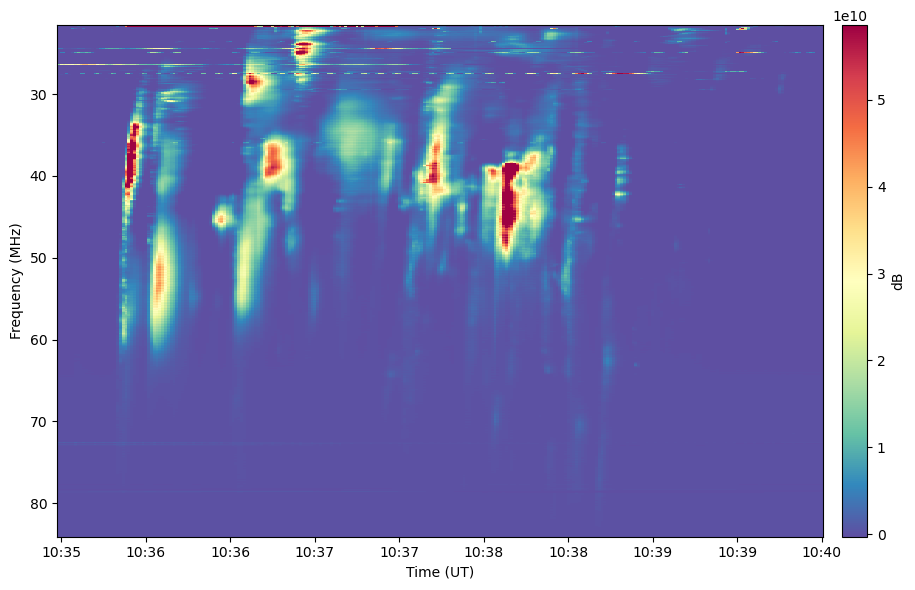

In [15]:
vmin = np.percentile(nenufar_nobkg_1s.values, 25)
vmax = np.percentile(nenufar_nobkg_1s.values, 99.7)
print(f'vmin={vmin:.2e}, vmax{vmax:.2e}')

fig = plt.figure(figsize=[10,6])
ax = fig.add_subplot(111)
pc = ax.pcolormesh(nenufar_nobkg_1s.index, nenufar_nobkg_1s.columns, nenufar_nobkg_1s.T,
                   vmin=vmin, vmax=vmax, cmap='Spectral_r')
fig.colorbar(pc, ax=ax, pad=0.02, label='dB')
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.set_ylim(ax.get_ylim()[::-1])  # Reverse Y axis for frequency descending
ax.xaxis_date()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
fig.tight_layout()
plt.show()

In [27]:
df = nenufar_nobkg_1s.copy()

def draw_bezier(x1=0, y1=0, x2=0, y2=0, controls=[[0,0]], n=2):
    if n == 2 and len(controls) != 1:
        raise ValueError("Quadratic Bézier requires exactly 1 control point.")
    elif n == 3 and len(controls) != 2:
        raise ValueError("Cubic Bézier requires exactly 2 control points.")
    
    P0 = np.array([x1, y1])
    P3 = np.array([x2, y2])
    t = np.linspace(0, 1, 100)

    if n == 2:
        P1 = np.array(controls[0])
        bezier_curve = (1 - t)[:, None] ** 2 * P0 + \
                       2 * (1 - t)[:, None] * t[:, None] * P1 + \
                       t[:, None] ** 2 * P3
    elif n == 3:
        P1 = np.array(controls[0])
        P2 = np.array(controls[1])
        bezier_curve = (1 - t)[:, None] ** 3 * P0 + \
                       3 * (1 - t)[:, None] ** 2 * t[:, None] * P1 + \
                       3 * (1 - t)[:, None] * t[:, None] ** 2 * P2 + \
                       t[:, None] ** 3 * P3
    return bezier_curve

def extract_bezier_values(array, x1, y1, x2, y2, controls, n):
    bezier_curve = draw_bezier(x1, y1, x2, y2, controls, n)
    x_coords = np.round(bezier_curve[:, 0]).astype(int)
    y_coords = np.round(bezier_curve[:, 1]).astype(int)
    x_coords = np.clip(x_coords, 0, array.shape[1] - 1)
    y_coords = np.clip(y_coords, 0, array.shape[0] - 1)
    bezier_values = array[y_coords, x_coords]
    return bezier_values, x_coords, y_coords

# Interactive plotting function
def interactive_bezier(X_start=82, Y_start=225, X_end=175, Y_end=20,
                       C1X=83, C1Y=37, C2X=84, C2Y=20):
    
    control = [[C1X, C1Y], [C2X, C2Y]]
    n = 3  # Cubic Bézier

    array      = df.T.values
    psudo_time = np.arange(array.shape[1])
    psudo_freq = np.arange(array.shape[0])

    fig = plt.figure(figsize=[10,6])
    ax  = fig.add_subplot(111)
    
    pc = ax.pcolormesh(psudo_time, psudo_freq, array, vmin=vmin, vmax=vmax, cmap='Spectral_r')

    _, x_coords, y_coords = extract_bezier_values(array, X_start, Y_start, X_end, Y_end, control, n)
    
    ax.plot(x_coords, y_coords, 'wx--', linewidth=1, markersize=3)
    ax.scatter(X_start, Y_start, c='r', ec='w', s=40, zorder=10, label='start')
    ax.scatter(X_end, Y_end, c='g', ec='w', s=40, zorder=10, label='end')
    ax.scatter(C1X, C1Y, c='blue', ec='w', s=40, zorder=10, label='control 1')
    ax.scatter(C2X, C2Y, c='cyan', ec='w', s=40, zorder=10, label='control 2')
    
    fig.colorbar(pc, ax=ax, pad=0.02, label='dB')
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.12), ncol=4)
    ax.set_xlabel('Time steps')
    ax.set_ylabel('Frequency steps')
    ax.grid(alpha=0.2)
    ax.set_ylim(ax.get_ylim()[::-1])  # Reverse Y axis for frequency descending
    fig.tight_layout()
    plt.show()

In [25]:
# Create interactive widgets
interact(interactive_bezier,
         X_start=widgets.IntSlider(min=0, max=200, step=1, value=82),
         Y_start=widgets.IntSlider(min=0, max=250, step=1, value=225),
         X_end=widgets.IntSlider(min=0, max=200, step=1, value=175),
         Y_end=widgets.IntSlider(min=0, max=250, step=1, value=20),
         C1X=widgets.IntSlider(min=0, max=200, step=1, value=83),
         C1Y=widgets.IntSlider(min=0, max=250, step=1, value=37),
         C2X=widgets.IntSlider(min=0, max=200, step=1, value=84),
         C2Y=widgets.IntSlider(min=0, max=250, step=1, value=20))

interactive(children=(IntSlider(value=82, description='X_start', max=200), IntSlider(value=225, description='Y…

<function __main__.interactive_bezier(X_start=82, Y_start=225, X_end=175, Y_end=20, C1X=83, C1Y=37, C2X=84, C2Y=20)>

In [71]:
from ipywidgets import FloatSlider, Layout, interact

# def draw_bezier(x1=0, y1=0, x2=0, y2=0, controls=[[0, 0]], n=3):
#     if n == 2 and len(controls) != 1:
#         raise ValueError("Quadratic Bézier requires 1 control point.")
#     elif n == 3 and len(controls) != 2:
#         raise ValueError("Cubic Bézier requires 2 control points.")
    
#     P0 = np.array([x1, y1])
#     P3 = np.array([x2, y2])
#     t = np.linspace(0, 1, 100)

#     if n == 2:
#         P1 = np.array(controls[0])
#         bezier_curve = (1 - t)[:, None]**2 * P0 + 2 * (1 - t)[:, None] * t[:, None] * P1 + t[:, None]**2 * P3
#     elif n == 3:
#         P1 = np.array(controls[0])
#         P2 = np.array(controls[1])
#         bezier_curve = (1 - t)[:, None]**3 * P0 + 3 * (1 - t)[:, None]**2 * t[:, None] * P1 + \
#                        3 * (1 - t)[:, None] * t[:, None]**2 * P2 + t[:, None]**3 * P3
#     return bezier_curve



# def draw_bezier(x1=0, y1=0, x2=0, y2=0, controls=[[0, 0]], n=2, num_points=100):
#     p0 = np.array([x1, y1])
#     p1 = np.array([x2, y2])
    
#     if n == 1:
#         # Linear Bézier (no control points)
#         if controls and len(controls) != 0:
#             raise ValueError('Linear Bézier should have 0 control points.')
#         t = np.linspace(0, 1, num_points)
#         curve = np.outer(1 - t, p0) + np.outer(t, p1)
    
#     elif n == 2:
#         # if len(controls) != 1:
#         #     raise ValueError("Quadratic Bézier requires 1 control point.")
#         c = np.array(controls[0])
#         t = np.linspace(0, 1, num_points)
#         # curve = ((1 - t)**2)[:, None] * p0 + 2 * ((1 - t) * t)[:, None] * c + (t**2)[:, None] * p1
#         curve = (1 - t)[:, None] ** 2 * p0 + 2 * (1 - t)[:, None] * t[:, None] * p1 + t[:, None] ** 2 * p3

#     elif n == 3:
#         if len(controls) != 2:
#             raise ValueError("Cubic Bézier requires 2 control points.")
#         c1 = np.array(controls[0])
#         c2 = np.array(controls[1])
#         t = np.linspace(0, 1, num_points)
#         curve = ((1 - t)**3)[:, None] * p0 + 3 * ((1 - t)**2 * t)[:, None] * c1 + \
#                 3 * ((1 - t) * t**2)[:, None] * c2 + (t**3)[:, None] * p1
#     else:
#         raise NotImplementedError(f"Bézier curve of order {n} is not supported.")

#     return curve

def draw_bezier(x1=0, y1=0, x2=0, y2=0, controls=[[0,0]], n=2, num_points=50):
    """
    Draw a Bézier curve of degree n using control points.
    
    Parameters:
    ===========
    - x1, y1: Start point coordinates.
    - x2, y2: End point coordinates.
    - controls: A list of control points, where:
        - 1 control point for n=2 (quadratic).
        - 2 control points for n=3 (cubic).
    - n: Degree of the Bézier curve (2 for quadratic, 3 for cubic).
    
    Returns:
    ========
    - bezier_curve: An array of points [x, y] that form the Bézier curve.
    """
    # if n == 2 and len(controls) != 1:
    #     raise ValueError("Quadratic Bézier requires exactly 1 control point.")
    # elif n == 3 and len(controls) != 2:
    #     raise ValueError("Cubic Bézier requires exactly 2 control points.")
    
    # Convert points to numpy arrays
    P0 = np.array([x1, y1])  # Start point
    P3 = np.array([x2, y2])  # End point
    
    # Create time steps t from 0 to 1
    t = np.linspace(0, 1, num_points)  # 100 points for smoothness

    if n == 2:  # Quadratic Bézier curve
        P1 = np.array(controls[0])  # Only 1 control point
        
        # Quadratic Bézier formula
        curve = (1 - t)[:, None] ** 2 * P0 + \
                       2 * (1 - t)[:, None] * t[:, None] * P1 + \
                       t[:, None] ** 2 * P3
    
    elif n == 3:  # Cubic Bézier curve
        if not any(np.isnan(controls[1])):
            P1 = np.array(controls[0])  # First control point
            P2 = np.array(controls[1])  # Second control point
            
            # Cubic Bézier formula
            curve = (1 - t)[:, None] ** 3 * P0 + \
                           3 * (1 - t)[:, None] ** 2 * t[:, None] * P1 + \
                           3 * (1 - t)[:, None] * t[:, None] ** 2 * P2 + \
                           t[:, None] ** 3 * P3
        else:
            P1 = np.array(controls[0])  # Only 1 control point
            
            # Quadratic Bézier formula
            curve = (1 - t)[:, None] ** 2 * P0 + \
                           2 * (1 - t)[:, None] * t[:, None] * P1 + \
                           t[:, None] ** 2 * P3
    
    return curve


def extract_bezier_values(array, x1, y1, x2, y2, controls, n):
    # if n==2:
    #     controls=controls[0]
    curve = draw_bezier(x1, y1, x2, y2, controls, n)
    x_coords = np.round(curve[:, 0]).astype(int)
    y_coords = np.round(curve[:, 1]).astype(int)
    
    # Keep within array bounds
    x_coords = np.clip(x_coords, 0, array.shape[1] - 1)
    y_coords = np.clip(y_coords, 0, array.shape[0] - 1)
    
    values = array[y_coords, x_coords]
    return values, x_coords, y_coords


n = 2
array      = df.T.values
psudo_time = np.arange(array.shape[1])
psudo_freq = np.arange(array.shape[0])

layout800 = Layout(width='800px')

# Sliders for start/end/control points
x_start = FloatSlider(min=0, max=df.shape[0], step=0.5, value=50, description='x_start', layout=layout800)
y_start = FloatSlider(min=0, max=df.shape[1], step=0.5, value=200, description='y_start', layout=layout800)
x_end   = FloatSlider(min=0, max=df.shape[0], step=0.5, value=150, description='x_end', layout=layout800)
y_end   = FloatSlider(min=0, max=df.shape[1], step=0.5, value=30, description='y_end', layout=layout800)

cx1 = FloatSlider(min=0, max=200, step=1, value=80, description='cx1', layout=layout800)
cy1 = FloatSlider(min=0, max=256, step=1, value=100, description='cy1', layout=layout800)
cx2 = FloatSlider(min=0, max=200, step=1, value=0, description='cx2', layout=layout800)
cy2 = FloatSlider(min=0, max=256, step=1, value=0, description='cy2', layout=layout800)

def update_plot(x_start, y_start, x_end, y_end, cx1, cy1, cx2, cy2):
    control_points = [[cx1, cy1], [cx2, cy2]]
    curve = draw_bezier(x_start, y_start, x_end, y_end, control_points, n)

    x_coords = np.round(curve[:, 0]).astype(int)
    y_coords = np.round(curve[:, 1]).astype(int)

    x_coords = np.clip(x_coords, 0, df.shape[1] - 1)
    y_coords = np.clip(y_coords, 0, df.shape[0] - 1)

    
    fig = plt.figure(figsize=[10,6])
    ax  = fig.add_subplot(111)
    
    pc = ax.pcolormesh(psudo_time, psudo_freq, array, vmin=vmin, vmax=vmax, cmap='Spectral_r')

    _, x_coords, y_coords = extract_bezier_values(array, x_start, y_start, x_end, y_end, control_points, n)
    
    ax.plot(x_coords, y_coords, 'wx--', linewidth=1, markersize=3)
    
    ax.scatter(x_start, y_start, c='r', ec='w', s=40, zorder=10, label='Start')
    ax.scatter(x_end, y_end, c='g', ec='w', s=40, zorder=10, label='End')
    ax.scatter(cx1, cy1, c='blue', ec='w', s=40, zorder=10, label='Control 1')
    ax.scatter(cx2, cy2, c='cyan', ec='w', s=40, zorder=10, label='Control 2')
    
    fig.colorbar(pc, ax=ax, pad=0.02, label='dB')
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.12), ncol=4)
    ax.set_xlabel('Time steps')
    ax.set_ylabel('Frequency steps')
    ax.grid(alpha=0.2)
    ax.set_ylim(ax.get_ylim()[::-1])  # Reverse Y axis for frequency descending
    fig.tight_layout()
    plt.show()

interact(update_plot, 
         x_start=x_start, y_start=y_start,
         x_end=x_end, y_end=y_end,
         cx1=cx1, cy1=cy1, cx2=cx2, cy2=cy2)

interactive(children=(FloatSlider(value=50.0, description='x_start', layout=Layout(width='800px'), max=272.0, …

<function __main__.update_plot(x_start, y_start, x_end, y_end, cx1, cy1, cx2, cy2)>

In [53]:
from ipywidgets import FloatSlider, IntSlider, VBox, Layout, interactive_output
import ipywidgets as widgets

# -----------------------
# Bézier drawing function
# -----------------------
def draw_bezier(x1, y1, x2, y2, controls, n=2, num_points=100):
    p0 = np.array([x1, y1])
    pN = np.array([x2, y2])
    t = np.linspace(0, 1, num_points)

    if n == 1:
        return np.array([(1 - ti) * p0 + ti * pN for ti in t])
    elif n == 2:
        if len(controls) != 1:
            raise ValueError("Quadratic Bézier requires 1 control point.")
        c = np.array(controls[0])
        return np.array([(1 - ti)**2 * p0 + 2 * (1 - ti) * ti * c + ti**2 * pN for ti in t])
    elif n == 3:
        if len(controls) != 2:
            raise ValueError("Cubic Bézier requires 2 control points.")
        c1 = np.array(controls[0])
        c2 = np.array(controls[1])
        return np.array([
            (1 - ti)**3 * p0 + 3 * (1 - ti)**2 * ti * c1 + 3 * (1 - ti) * ti**2 * c2 + ti**3 * pN
            for ti in t
        ])
    else:
        raise ValueError("Only degree 1, 2, or 3 Bézier supported.")

# -----------------------
# image array
# -----------------------
array      = df.T.values
psudo_time = np.arange(array.shape[1])
psudo_freq = np.arange(array.shape[0])

# -----------------------
# Slider definitions
# -----------------------
slider_layout = Layout(width='600px')

n_slider = IntSlider(value=2, min=1, max=3, description='Degree n', layout=slider_layout)

x_start = FloatSlider(value=10, min=0, max=99, step=1, description='x_start', layout=slider_layout)
y_start = FloatSlider(value=10, min=0, max=99, step=1, description='y_start', layout=slider_layout)
x_end   = FloatSlider(value=90, min=0, max=99, step=1, description='x_end', layout=slider_layout)
y_end   = FloatSlider(value=90, min=0, max=99, step=1, description='y_end', layout=slider_layout)

cx1 = FloatSlider(value=50, min=0, max=99, step=1, description='cx1', layout=slider_layout)
cy1 = FloatSlider(value=70, min=0, max=99, step=1, description='cy1', layout=slider_layout)
cx2 = FloatSlider(value=70, min=0, max=99, step=1, description='cx2', layout=slider_layout)
cy2 = FloatSlider(value=30, min=0, max=99, step=1, description='cy2', layout=slider_layout)

# Group sliders
control1_box = VBox([cx1, cy1])
control2_box = VBox([cx2, cy2])

# -----------------------
# Visibility control
# -----------------------
def toggle_control_visibility(change=None):
    n = n_slider.value
    if n == 1:
        control1_box.layout.display = 'none'
        control2_box.layout.display = 'none'
    elif n == 2:
        control1_box.layout.display = ''
        control2_box.layout.display = 'none'
    elif n == 3:
        control1_box.layout.display = ''
        control2_box.layout.display = ''

# Call once to set initial visibility
toggle_control_visibility()
n_slider.observe(toggle_control_visibility, names='value')

# -----------------------
# Plotting function
# -----------------------
def update_plot(n, x_start, y_start, x_end, y_end, cx1, cy1, cx2, cy2):
    control_points = []
    if n == 2:
        control_points = [[cx1, cy1]]
    elif n == 3:
        control_points = [[cx1, cy1], [cx2, cy2]]

    bezier = draw_bezier(x_start, y_start, x_end, y_end, control_points, n=n)
    x_coords, y_coords = bezier[:, 0], bezier[:, 1]

    fig, ax = plt.subplots(figsize=[10,6])
    ax.pcolormesh(psudo_time, psudo_freq, array, vmin=vmin, vmax=vmax, cmap='Spectral_r')
    ax.plot(x_coords, y_coords, 'w--', label=f'Bézier n={n}')
    ax.scatter([x_start, x_end], [y_start, y_end], c='r', s=60, edgecolors='white', label='Start/End')
    
    for cp in control_points:
        ax.scatter(*cp, c='lime', s=50, edgecolors='black', label='Control point')

    ax.invert_yaxis()
    ax.legend()
    fig.tight_layout()
    plt.show()

# -----------------------
# Interactive Output
# -----------------------
interact_out = interactive_output(update_plot, {
    'n': n_slider,
    'x_start': x_start,
    'y_start': y_start,
    'x_end': x_end,
    'y_end': y_end,
    'cx1': cx1,
    'cy1': cy1,
    'cx2': cx2,
    'cy2': cy2,
})

# Display all together
ui = VBox([
    n_slider,
    x_start, y_start,
    x_end, y_end,
    control1_box,
    control2_box
])

display(ui, interact_out)

Output()